In [1]:
import sys
sys.path.append("/home/huaqingj/MyResearch/TVDN")

In [2]:
from pyTVDN import TVDNDetect
from pathlib import Path
from scipy.io import loadmat
from scipy.signal import detrend
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
from scipy.signal import lfilter, firls, decimate

In [4]:
from pprint import pprint
import pickle
from easydict import EasyDict as edict
import warnings
from pyTVDN.TVDNutils import *
from pyTVDN.utils import in_notebook
if in_notebook():
    from tqdm import tqdm_notebook as tqdm
else:
    from tqdm import tqdm

class TVDNDetect1(TVDNDetect):
    def TuningKappaNew(self, kappas):
        assert self.finalRes is not None, "Run main function first!"
        
        MaxM = self.paras.MaxM
        U0 = self.finalRes.U0 
        rAct, n = self.midRes.nXmat.shape
        r = self.paras.r
        Us = []
        for kappac in kappas:
            Us.append(U0 + 2*r*np.log(n)**kappac* (np.arange(1, MaxM+2)))
        Us = np.array(Us)
        numchgs = Us.argmin(axis=1)
        self.numchgs = numchgs
        argIdx = np.argmin(np.diff(numchgs)/np.diff(kappas))
        
        self.Us = Us
        mUs = Us.min(axis=1)
        argmU = np.argmin(mUs)
        
        chgsKappas = []
        for numchg in numchgs:
            chgsKappas.append(self.finalRes.chgMat[numchg-1, :numchg])
        
        res = edict()
        res.kp1 = kappas[argIdx+1]
        res.numChgs1 = numchgs[argIdx+1]
        res.cpts1 = self.finalRes.chgMat[res.numChgs1-1, :res.numChgs1] 
        res.kp2 = kappas[argmU]
        res.numChgs2 = numchgs[argmU]
        res.cpts2 = self.finalRes.chgMat[res.numChgs2-1, :res.numChgs2] 
        res.chgsKappas = chgsKappas
        
        return res
   

In [5]:
def dHdist(set1, set2, n=155):
    set1 = np.array(set1)
    set2 = np.array(set2)
    if len(set2) == 0:
        return 0
    if len(set1) == 0:
        return n
    else:
        absDiff = np.abs(set1.reshape(-1, 1) - set2.reshape(1, -1))
        return absDiff.min(axis=0).max()

In [6]:
def Hdist(set1, set2, n=155):
    d1 = dHdist(set1, set2, n=n)
    d2 = dHdist(set2, set1, n=n)
    return np.max((d1, d2))

In [7]:
dHdist([1, 2, 3, 4, 5], [1,2 ,3, 4])

0

In [8]:
resDir = Path("../results")
dataDir = Path("../data")

In [9]:
filname = Path("fMRI_samples.mat")
fMRIs = loadmat(dataDir/filname)["clean_subjects"]

# 1. Obtain data after HPF

In [10]:
fs = 0.5 #sampling frequency
fmin = 0.009 # 
fmax = 0.08
hbp = firls(21, np.array([0, 0.009, 0.01, 0.08, 0.09, 0.8]), #0.8
           desired = np.array([0, 0, 1, 1, 0, 0]))

In [11]:
num = 243
fMRIsHPF = []
for i in range(num):
    cfMRI = fMRIs[0, i]["fMRI"][:90, :]
    # detrend
    cfMRI = detrend(cfMRI)
    chpffMRI = lfilter(hbp, 1, cfMRI)
    fMRIsHPF.append(chpffMRI[:, 25:])

### sample plots 

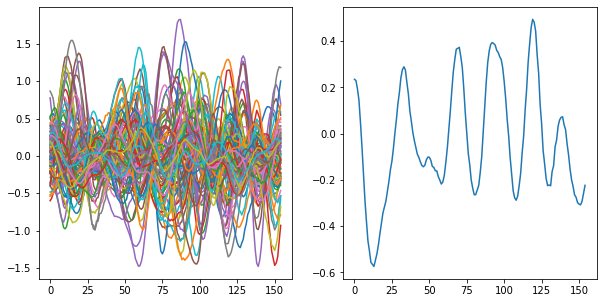

In [12]:
plt.figure(figsize=[10, 5])
plt.subplot(121)
for i in range(90):
    plt.plot(fMRIsHPF[4][i, :])
    
plt.subplot(122)
plt.plot(fMRIsHPF[4][10, :])

# 2. Obtain seamed data

1. divide whole data into `k` segments
2. the grand truth are different for different data

In [13]:
def GenRanCpts(ncpt, Lmin, n=155):
    Mdiff = 0
    
    while (Mdiff <=Lmin):
        cpts = np.random.choice(n, size=ncpt, replace=False)
        cpts = np.sort(cpts)
        Mdiff = np.min(np.abs(np.diff(cpts)))
        Mdiff = np.min((cpts[0], Mdiff, n-cpts[-1]))
    return cpts

In [15]:
#GTs = np.array([
#   [30, 85, 130],
#   [20, 55, 80],
#   [80, 105, 135],
#   [35, 65, 100],
#   [50, 105, 125]
#] * 5)

numchgs = [3, 4, 5, 6, 5, 6, 4, 3, 5, 6]
GTs = [list(GenRanCpts(i, Lmin=15)) for i in numchgs]

GTsAll = []
for GT in GTs:
    numD = len(GT) + 1
    GTsAll = GTsAll + [GT] * numD

In [16]:
len(GTsAll)

57

In [17]:
d, n = fMRIsHPF[0].shape

In [18]:
seamedDatas = []
idxC = 0
for GT in GTs:
    GT = np.array(GT)
    numD = len(GT) + 1
    GT = GT - 1
    GT2 = np.concatenate([GT, [n]]) + 1 
    GT1 = np.concatenate([[0], GT+1])
    cDs = [np.zeros((d, n)) for ii in range(numD)]
    for k in range(numD):
        for l in range(numD):
            cDs[l][:, GT1[k]:GT2[k]] = fMRIsHPF[idxC+(k+l)%numD][:, GT1[k]:GT2[k]]
    idxC += numD
    seamedDatas = seamedDatas + cDs

### Verify the seamed data

In [19]:
#seamedDatas[11][:, 120:] - fMRIsHPF[10][:, 120:]

### sample plots 

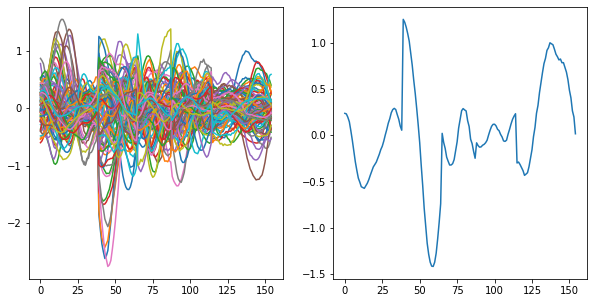

In [20]:
plt.figure(figsize=[10, 5])
plt.subplot(121)
for i in range(90):
    plt.plot(seamedDatas[4][i, :])
    
plt.subplot(122)
plt.plot(seamedDatas[4][10, :])

# 3. Detection for kappa

In [21]:
kappa = 1.53
r = 10
Lmin = 15

results = []
kappas = np.arange(0.68, 4, 0.01)
thdist = 0
for i in tqdm(range(len(seamedDatas))):
    Ymat = seamedDatas[i]
    simuDet = TVDNDetect1(Ymat=Ymat,  saveDir=None, dataType="fMRI", Lmin=Lmin, downRate=4, fct=1, T=2, MaxM=20, 
                        fName="fMRI_HPF", r=r, kappa=1, freq=0.5, lamb=1e-3, showProgress=False, 
                          decimateRate=None, is_detrend=False)
    simuDet()
    GT = GTsAll[i]
    ecpts = simuDet.finalRes.chgMat[len(GT)-1, :len(GT)]
    chdist = Hdist(ecpts, GT)
    thdist += chdist
    
    print(i+1, np.round(thdist/(i+1), 3), Hdist(ecpts, GT), ecpts, GT)
    res = simuDet.TuningKappaNew(kappas)
    results.append(res.chgsKappas)

1 24.0 24.0 [ 48.  84. 122.] [24, 86, 106]
2 18.5 13.0 [ 36.  73. 117.] [24, 86, 106]
3 17.0 14.0 [ 38.  85. 117.] [24, 86, 106]
4 19.0 25.0 [ 30.  61. 107.] [24, 86, 106]
5 16.4 6.0 [ 33.  61.  90. 116.] [39, 65, 88, 115]
6 14.667 6.0 [ 37.  68.  93. 121.] [39, 65, 88, 115]
7 13.857 9.0 [ 35.  56.  85. 114.] [39, 65, 88, 115]
8 12.375 2.0 [ 37.  63.  90. 115.] [39, 65, 88, 115]
9 11.667 6.0 [ 34.  64.  82. 113.] [39, 65, 88, 115]
10 11.4 9.0 [ 28.  60.  82. 105. 129.] [20, 62, 82, 109, 138]
11 10.909 6.0 [ 26.  56.  79. 106. 133.] [20, 62, 82, 109, 138]
12 11.25 15.0 [ 35.  63.  89. 107. 135.] [20, 62, 82, 109, 138]
13 11.538 15.0 [ 35.  61.  81. 103. 123.] [20, 62, 82, 109, 138]
14 11.857 16.0 [ 23.  53.  77.  97. 122.] [20, 62, 82, 109, 138]
15 12.067 15.0 [ 22.  48.  71.  95. 123.] [20, 62, 82, 109, 138]
16 11.625 5.0 [ 17.  34.  57.  85. 101. 125.] [16, 34, 62, 88, 105, 130]
17 11.588 11.0 [ 22.  45.  70.  90. 110. 138.] [16, 34, 62, 88, 105, 130]
18 11.333 7.0 [ 17.  41.  67.  84

In [41]:
hdists = []
for k, ress in enumerate(results):
    GT = GTsAll[k]
    hdist = [Hdist(res, GT)for res in ress]
    hdists.append(hdist) 

In [42]:
hdists = np.array(hdists)

In [43]:
mhdist = hdists.mean(axis=0)

In [44]:
np.min(mhdist)

15.298245614035087

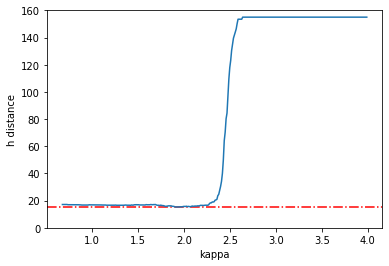

In [45]:
plt.xlabel("kappa")
plt.ylabel("h distance")
plt.ylim([0, 160])
plt.axhline(Lmin, color="red", linestyle="-.")
plt.plot(kappas, mhdist)

In [63]:
optKappa = kappas[np.argmin(mhdist)];optKappa

1.910000000000001

## Data 9

In [86]:
fMRI = fMRIs[0, 9]["fMRI"][:90, :]
fMRI = detrend(fMRI)
hpffMRI = lfilter(hbp, 1, fMRI)
hpffMRI = hpffMRI[:, 25:]

In [87]:
r = 10 
Lmin = 15

In [88]:
fMRIDet = TVDNDetect1(Ymat=hpffMRI,  saveDir=None, dataType="fMRI", Lmin=Lmin, downRate=4, fct=1, T=2, MaxM=20, 
                        fName="fMRI_HPF", r=r, kappa=optKappa, freq=0.5, lamb=1e-4, showProgress=True, 
                          decimateRate=None, is_detrend=False)
fMRIDet()

The parameters for detection are:
{'Lmin': 15,
 'MaxM': 20,
 'T': 2,
 'decimateRate': None,
 'downRate': 4,
 'fName': 'fMRI_HPF',
 'fct': 1,
 'freq': 0.5,
 'is_detrend': False,
 'kappa': 1.910000000000001,
 'lamb': 0.0001,
 'nbasis': 10,
 'r': 10}


## Results under the optimal kappa

In [89]:
print(fMRIDet)

+-------------+-----------------------+-------------------+------+
| Num of CPTs |     Estiamted CPTs    |        MSE        | Rank |
+-------------+-----------------------+-------------------+------+
|      5      | [ 30  55  81 106 126] | 4.134185915048578 |  10  |
+-------------+-----------------------+-------------------+------+


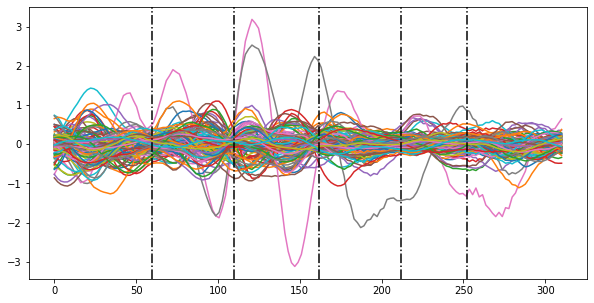

In [90]:
fMRIDet.PlotEcpts()

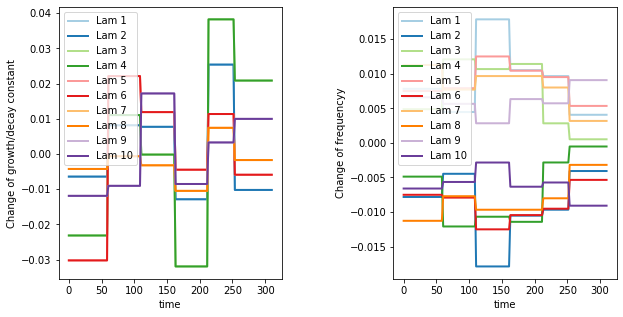

In [91]:
fMRIDet.PlotEigenCurve()

## Results for tuning kappa with MSE

In [92]:
fMRIDet.TuningKappa(kappas)

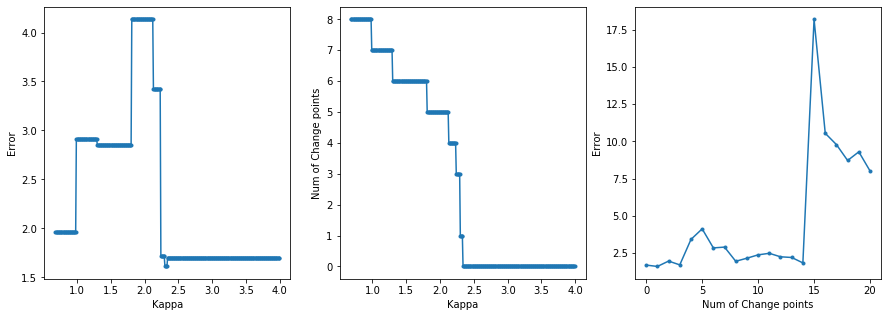

In [93]:
fMRIDet.PlotKappaErrCurve()

In [94]:
fMRIDet.UpdateEcpts()

The plot indices are [27 89 41  8 84].


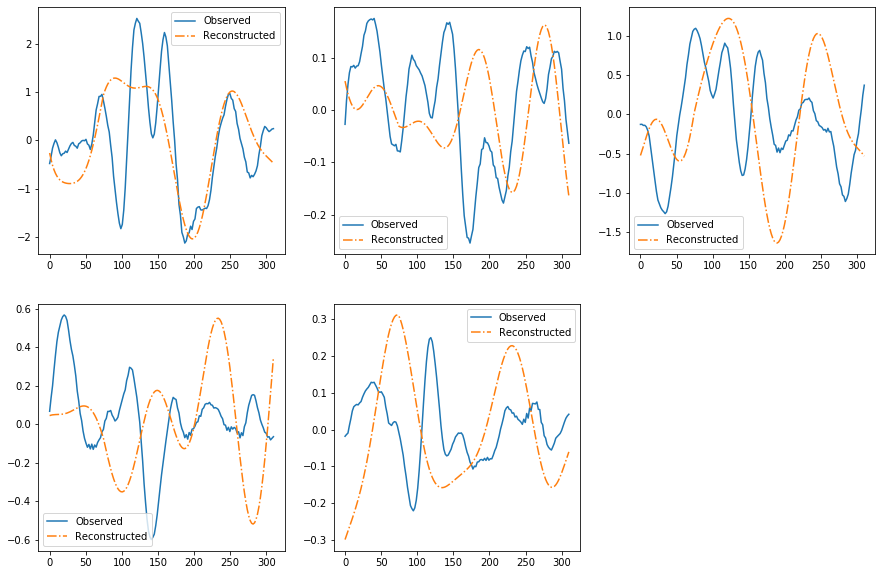

array([27, 89, 41,  8, 84])

In [95]:
fMRIDet.PlotRecCurve()

In [96]:
print(fMRIDet)

+-------------+----------------+--------------------+------+
| Num of CPTs | Estiamted CPTs |        MSE         | Rank |
+-------------+----------------+--------------------+------+
|      1      |     [38.]      | 1.6126008699524563 |  10  |
+-------------+----------------+--------------------+------+


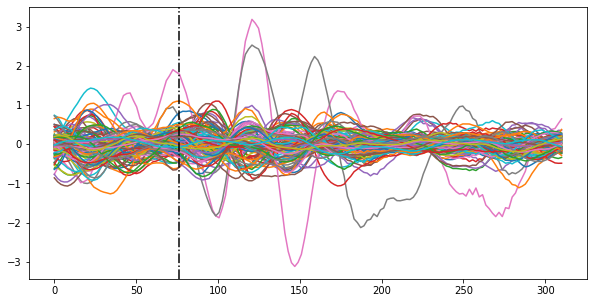

In [97]:
fMRIDet.PlotEcpts()

## Data 100

In [98]:
fMRI = fMRIs[0, 100]["fMRI"][:90, :]
fMRI = detrend(fMRI)
hpffMRI = lfilter(hbp, 1, fMRI)
hpffMRI = hpffMRI[:, 25:]

In [99]:
r = 10 
Lmin = 15

In [100]:
fMRIDet = TVDNDetect1(Ymat=hpffMRI,  saveDir=None, dataType="fMRI", Lmin=Lmin, downRate=4, fct=1, T=2, MaxM=20, 
                        fName="fMRI_HPF", r=r, kappa=optKappa, freq=0.5, lamb=1e-4, showProgress=True, 
                          decimateRate=None, is_detrend=False)
fMRIDet()

The parameters for detection are:
{'Lmin': 15,
 'MaxM': 20,
 'T': 2,
 'decimateRate': None,
 'downRate': 4,
 'fName': 'fMRI_HPF',
 'fct': 1,
 'freq': 0.5,
 'is_detrend': False,
 'kappa': 1.910000000000001,
 'lamb': 0.0001,
 'nbasis': 10,
 'r': 10}


## Results under the optimal kappa

In [101]:
print(fMRIDet)

+-------------+---------------------------+--------------------+------+
| Num of CPTs |       Estiamted CPTs      |        MSE         | Rank |
+-------------+---------------------------+--------------------+------+
|      6      | [ 28  49  68  88 110 132] | 1.0886552086854984 |  10  |
+-------------+---------------------------+--------------------+------+


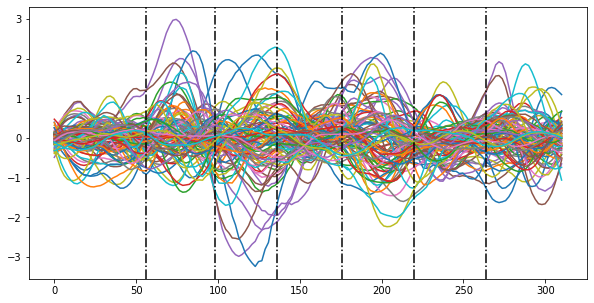

In [102]:
fMRIDet.PlotEcpts()

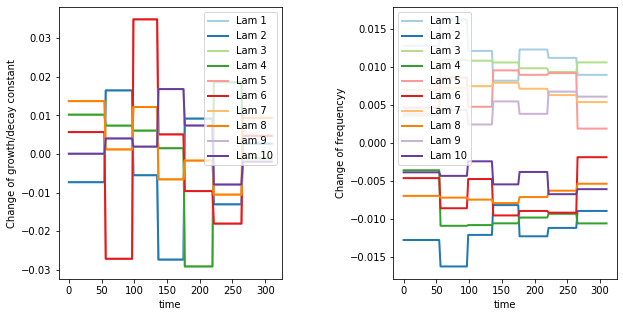

In [103]:
fMRIDet.PlotEigenCurve()

## Results for tuning kappa with MSE

In [104]:
fMRIDet.TuningKappa(kappas)

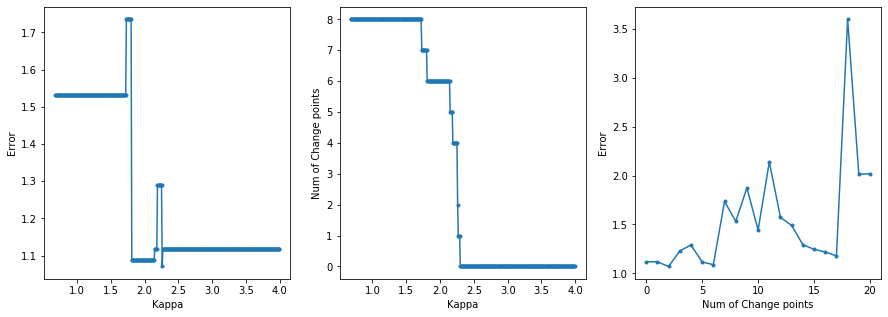

In [105]:
fMRIDet.PlotKappaErrCurve()

In [106]:
fMRIDet.UpdateEcpts()

The plot indices are [16 86 56 66 67].


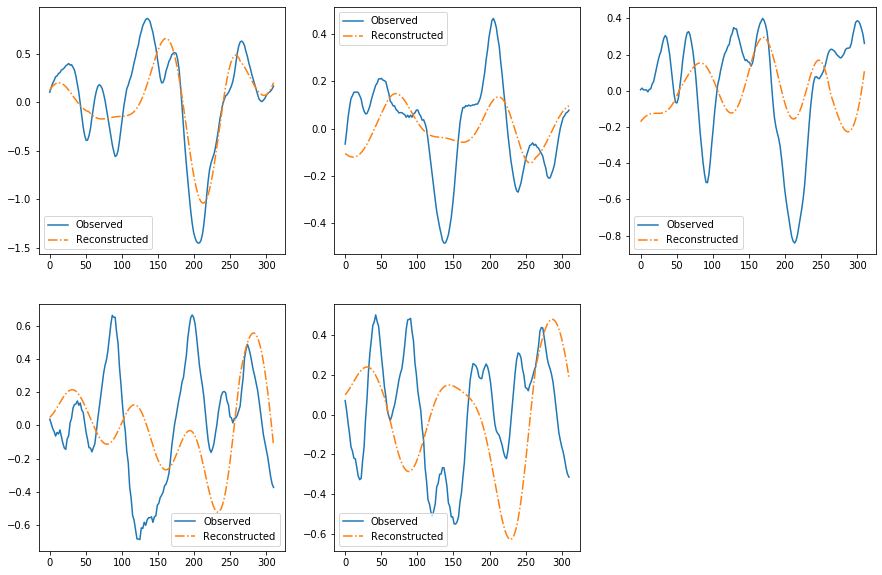

array([16, 86, 56, 66, 67])

In [107]:
fMRIDet.PlotRecCurve()

In [108]:
print(fMRIDet)

+-------------+----------------+------------------+------+
| Num of CPTs | Estiamted CPTs |       MSE        | Rank |
+-------------+----------------+------------------+------+
|      2      |  [ 28. 132.]   | 1.07084549964563 |  10  |
+-------------+----------------+------------------+------+


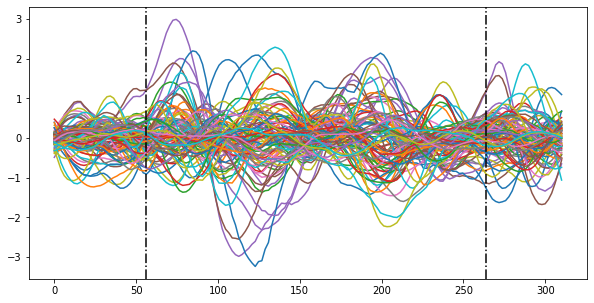

In [109]:
fMRIDet.PlotEcpts()